# Info1998 Final Project

Through webscraping Zillow: we explore what factors come into play when determining the final sold price of a house.

<b>NetIDs:</b> xt73, mz546, ab2674

____

## Introduction to American Housing Market: as Seen on Zillow

In the recent years, the deviation between listed market price and final sold price of a house is vastly different, depending on multiple factors such as the house's neighborhood, lot and living area, number of bed and bathrooms, time of the year, and how many people currently are looking at this house. 

Some of the factors that determine the deviation between market and final sold price are:
<ul>
<li>Neighborhood that the house resides in: proximity to schools, restaurants, commercial outlets, public transportation, etc.
<li>Year the house was built.
<li>The furnishing status of the house: or how well the current owners have designed the house's exterior and interior.
<li>Amount of people currently interested in this house: as more and more people send their offers in for the house, prices may skyrocket.
<li>Number of bedrooms and bathrooms.
</ul>


In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import lxml as lxml
from parsel import Selector
import threading

C:\Users\Sophia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Lets Webscrape Zillow
Lets first narrow down the scope of the housing market to that in Somerset, NJ. To start with this exploration, we first need to gain some data on the houses currently on the market in Zillow.

In [2]:
links = list()
results = list()
pool = list()
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Chrome/124.0.6367.60'
}   

Class for webscraping a search page on Zillow. First all the data stored in the "script#__NEXT_DATA__::text" portion of the website's inspect page will be saved in the "data" variable, where all the urls from the search page's house propertycards are filtered out and appended to the list "links". Then, conducts a second round of webscraping, where all filtered links will be accessed and scraped concurrently through multithreading (each link's scraping process is ran on an independent thread in attempts to optimize the process). Once all threads in the threadpool have completed their individual scraping tasks, all the scraped data appended to "results" will be both returned and also saved to an external json file for potential outside usage.

In [117]:
class WebScrape(object):
    links = list()
    results = list()
    pool = list()
    req_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Chrome/124.0.6367.60'
    }   

    ###
    def scrape(self, url):
        r = requests.get(url, headers = self.req_headers)
        print("Status code: " + str(r.status_code))
        selector = Selector(r.text)
        data = selector.css("script#__NEXT_DATA__::text").get()
        data = data.replace("{", "").replace("}", "").replace("[", "").replace("]", "").replace(",", "").split('"')
        for i in range(0, len(data)):
            self.links.append(data[i]) if ("homedetails" in data[i]) and not data[i] in self.links else None


        for n in range(0, len(self.links)):
            self.pool.append(threading.Thread(target = self.target, args = (n,)))
            self.pool[-1].start()

        # wait for all threads in pool to finish before next line runs
        for thread in self.pool: thread.join()

        # if len(l) = 1, then user inputted link
        with open("data.json", "w") as f:
            json.dump(self.results, f)
        
        return self.results
    
    def fromJson(self, source):
        f = open(source)
        data = json.load(f)
        return data
    
    ### The task that will be run by our threads.
    def target(self, n):
            r = requests.get(self.links[n], headers = self.req_headers)
            selector = Selector(r.text)
            data = selector.css("script#__NEXT_DATA__::text").get()
            if data:
                data = json.loads(data)
                property_data = json.loads(data["props"]["pageProps"]["componentProps"]["gdpClientCache"])
                property_data = property_data[list(property_data)[0]]['property']
            else:
                # Option 2: other times it's in Apollo cache
                data = selector.css("script#hdpApolloPreloadedData::text").get()
                data = json.loads(json.loads(data)["apiCache"])
                property_data = next(
                    v["property"] for k, v in data.items() if "ForSale" in k
                )
            self.results.append(property_data)

    ### After all the data has been scraped through running tasks on individual threads, we will filter the resulting data into a dataframe.
    def getDataFrame(self, results):
        df = pd.DataFrame(columns=["city", "state", "home status", "street address", "bedrooms", "bathrooms", "sold price", "rate of price change", 
                                   "sale price", "year built", "county", "home type", "monthly HOA", "zestimate", 
                                   "nearby schools", "tax paid", "rate of tax change", "mortgage rate", "url"])

        for dict in results:
            schools = [school.get("name") for school in dict.get("schools")]
            rating = [rate.get("rating") for rate in dict.get("schools")]
            nearby_schools = [{schools[n] : rating[n]} for n in range(0, len(schools))]
            try:
                price_sold = dict.get("priceHistory")[0].get("price")
            except:
                price_sold = None
            try:
                price_sale = dict.get("priceHistory")[1].get("price")
            except:
                price_sale = None
            try: 
                tax_paid = dict.get("taxHistory")[0].get("taxPaid")
            except: 
                tax_paid = None
            try:
                tax_inc = dict.get("taxHistory")[0].get("taxIncreaseRate")
            except:
                tax_inc = None
            try :
                price_inc = dict.get("priceHistory")[0].get("priceChangeRate")
            except:
                price_inc = None

            df.loc[len(df.index)] = [dict.get("city"), dict.get("state"), dict.get("homeStatus"), dict.get("address").get("streetAddress"), 
                                    dict.get("bedrooms"), dict.get("bathrooms"), price_sold, price_inc, price_sale,
                                    dict.get("yearBuilt"), dict.get("county"), dict.get("homeType"), 
                                    dict.get("monthlyHoaFee"), dict.get("zestimate"), nearby_schools, tax_paid, tax_inc,  
                                    dict.get("mortgageRates").get("thirtyYearFixedRate"), "zillow.com" + dict.get("hdpUrl")]
            
        return df

In [132]:
ws = WebScrape()
results = ws.scrape(url = "https://www.zillow.com/somerset-county-nj/sold/?searchQueryState=%7B%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22north%22%3A40.758005%2C%22south%22%3A40.374397%2C%22east%22%3A-74.401839%2C%22west%22%3A-74.797841%7D%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22rs%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A2552%2C%22regionType%22%3A4%7D%5D%2C%22pagination%22%3A%7B%7D%7D")

Status code: 200


# High chances are that Zillow will block the above webscraping attempts.
If Zillow blocks the scraping attempts from the above methods, initialize our dataframe using a CSV file that contains Zillow data sourced from a previously successful webscraping attempt.
Uncomment this codeblock if the above methods were not called successfully. As in r.status_code = 403, 404.
Access this json file through: https://drive.google.com/file/d/1q1FrgbFisFgotmNbXP-ATsoQb0o5UePq/view?usp=sharing

In [ ]:
#results = ws.fromJson("zillowdata.json")

# Cleaning Up Our Data

Lets first construct a dataframe "df" containing all the housing data obtained through webscraping and save a seperate dataframe containing only non-categorical (numerical) data.

In [213]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [142]:
df = ws.getDataFrame(results)
year_median = df['year built'].median(skipna=True)
for i in range(0, len(df['year built'])):
    if (df['year built'][i] == None):
        df['year built'][i] = int(year_median)

tax_median = df['rate of tax change'].median(skipna=True)
df['rate of tax change'] = df['rate of tax change'].fillna(tax_median)

paid_median = df['tax paid'].median(skipna=True)
df['tax paid'] = df['tax paid'].fillna(paid_median)

mortgage_median = df['mortgage rate'].median(skipna=True)
df['mortgage rate'] = df['mortgage rate'].fillna(mortgage_median)

enc = LabelEncoder()
enc.fit(df["city"])
df["encoded city"] = enc.transform(df["city"])

df_categorical = df.copy().select_dtypes(include='object')

C:\Users\Sophia\AppData\Local\Temp\ipykernel_33176\4092316400.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df.index)] = [dict.get("city"), dict.get("state"), dict.get("homeStatus"), dict.get("address").get("streetAddress"),
C:\Users\Sophia\AppData\Local\Temp\ipykernel_33176\4092316400.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df.index)] = [dict.get("city"), dict.get("state"), dict.get("homeStatus"), dict.get("address").get("streetAddress"),
C:\Users\Sophi

# Decision Tree Model

Lets first find the four features that correlate most with "sold price".

In [143]:
df_noncategorical = df.copy().select_dtypes(include=['float64', 'int64'])

matrix = df_noncategorical.corr()
target = matrix.loc["sold price"]
four = abs(matrix.loc["sold price"]-1).sort_values().tail(3)

Lets find the best max depth for our decision tree using a loop.

In [214]:
features = df_noncategorical[four.keys()]
target = df_noncategorical['sold price']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
train_scores = []
test_scores = []

max_depths = list(range(1,20))
for i in max_depths:
    model = DecisionTreeClassifier(max_depth=i)

    model.fit(x_train, y_train)

    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))


trainScore = model.score(x_train, y_train) 
validation = model.score(x_test, y_test) 


    tax paid  rate of tax change  mortgage rate  rate of price change
0   19867.09            0.071361          6.870              0.025023
1   13174.21            0.109297          6.870              0.000596
2   15204.96            0.071361          6.870              0.068884
3   12986.96            0.036540          6.870              0.047182
4   11134.15            0.033450          6.948              0.117647
..       ...                 ...            ...                   ...
77  13174.21            0.109297          6.870              0.000596
78  17021.45            0.001607          6.870              0.030043
79   7646.76            0.036715          6.948             -0.025000
80  10733.93           -0.010418          6.870              0.075862
81   7123.05            0.092957          6.870             -0.046823

[82 rows x 4 columns]


In [211]:
print("Test Accuracy: ", trainScore)
print("Training Accuracy: ", validation)

Test Accuracy:  0.9538461538461539
Training Accuracy:  0.8235294117647058


# Linear Regression Model

In [5]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [128]:
class Model(object): 
    def linearModel(self, tax, salePrice, bedrooms, df1): 
        df = df1.copy() 
        df = df.dropna(axis=0, subset = ['tax paid', 'sale price', 'bedrooms', 'sold price'])

        features = df[['tax paid', 'sale price', 'bedrooms']] 
        target = df['sold price'] 
        x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        model = LinearRegression() 
        model.fit(x_train, y_train) 
        
        predicted = model.predict([[tax, salePrice, bedrooms]])[0] 
        trainScore = model.score(x_train,y_train) 
        validation = model.score(x_test,y_test) 
        
        values = [predicted, trainScore, validation] 
        return values 

Lets predict the sold price of a house in Somerset, NJ with a sale price of $380,000, tax paid of $7000, and 3 bedrooms.

In [129]:
model = Model() 
values = model.linearModel(7000, 380000, 3, df) 
print('Linear Regression Model: prediction of selling price is %.2f, with a training score of %.2f and a validation score of %.2f' % (values[0], values[1], values[2]))


Linear Regression Model: prediction of selling price is 411920.32, with a training score of 0.97 and a validation score of 0.97


c:\Users\Sophia\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Visualizations

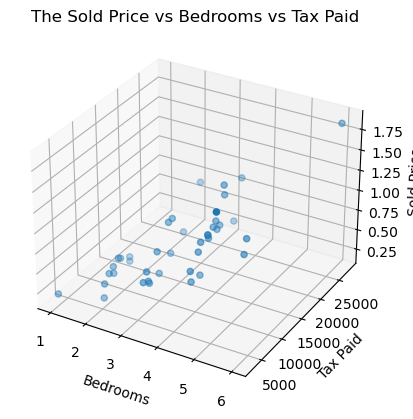

In [130]:
df = df.copy().dropna(axis=0, subset = ['bedrooms', "tax paid", "sold price"])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['bedrooms'], df['tax paid'], df['sold price']) 

ax.set_title('The Sold Price vs Bedrooms vs Tax Paid')
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Tax Paid')
ax.set_zlabel('Sold Price') 

plt.show()

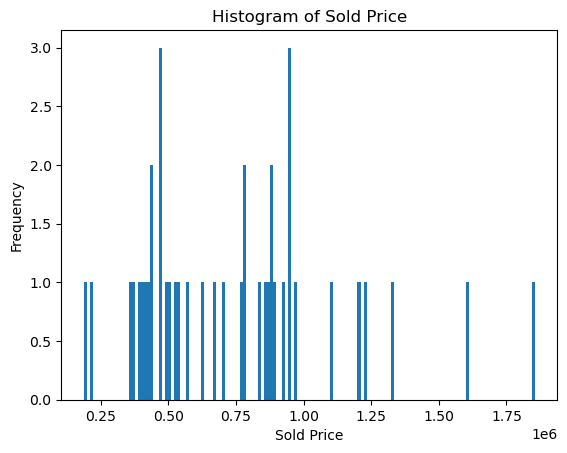

In [131]:
df = df.copy().dropna(axis=0, subset = ['sold price'])
plt.hist([df['sold price']],150,align='mid')

# Add a title
plt.title('Histogram of Sold Price')

# Add x and y labels
plt.xlabel('Sold Price')
plt.ylabel('Frequency')

# Show the plot!
plt.show()

# Conclusion

Through using a correlation matrix, we found that the four features most correlated with the final sold price of a house are tax paid, rate of tax change, mortgage rate, and rate of price change. We used both decision trees and linear regression to predict the final sold price and found that, based on training and testing validation scores that the linear regression model was more accurate in predicting our target. 